# Task Description

The objective of this task is to select sequential experiments such that we find the most accurate estimates of densities across the space of cell states (as defined by transcriptional profiles) with the smallest number of experiments.

# Set up Environment

Import a bunch of packages that we'll use for the task and import the libraries that will be necessary

In [1]:
# Script for multiple runs of wanderlust 
%load_ext autoreload
%autoreload 2

import warnings

# data processing
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    import scanpy.api as sc
import numpy as np
import scanpy.api as sc
import pandas as pd
import os
import scipy.sparse as sp

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# change logging settings for scanpy
sc.settings.verbosity = 4  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.settings.n_jobs = 30
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()

font search path ['/opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
generated new fontManager
Running Scanpy 0+unknown on 2018-04-08 17:29.
Dependencies: anndata==0.5.8 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 


# Functions and classes

We define two classes and one method below that are used in this task

1. **`SamplingDistanceEstimator`:** This class is used to calculate a sample's coverage of the cell states in the ground truth manifold. A low distance represents high coverage, and the goal of this task is to minimize this distance while sampling (1) as few cells as possible and (2) as few times as possible. 

2. **`ImputedSingleCellData`:** This class is used to hold single cell data that has been imputed (smoothed) with MAGIC to eliminate drop-out and more closely mimic the results of a FACS experiment. Gating strategies are applied over this imputed dataset. 

3. **`sample_masked`:** This class takes a mask generated by `ImputedSingleCellData` and the raw data matrix and returns a random sample of genes from the raw data whose imputed expression values fall within the gate. 

In [2]:
from sklearn.metrics import pairwise_distances
def _find_cell_indices(adata, cells):
    """Function to find cell indices given index in the AnnData object
    """
    return np.where(adata.obs_names.isin(cells))[0]
        
class SamplingDistanceEstimator:

    def __init__(self, adata: sc.AnnData, ref_set_sigmas: pd.Series, ):
        """Class the computes the distance for the subsample. The score determines the 
        fraction of reference spheres that are unoccupied
        
        :param sc.AnnData adata: Scanpy AnnData object containing the normalized count matrix
        :param pd.Series ref_set_sigmas: Pandas series representing the radii of the 
        reference set
        """
        
        if any(~ref_set_sigmas.index.isin(adata.obs_names)):
            raise ValueError(
                'Some of the cells in the reference set are not in the AnnData object. '
                'Ensure that all the reference cells are in the AnnData object'
            )
        
        self.adata = adata
        self.ref_set = _find_cell_indices(adata, ref_set_sigmas.index)
        self.sigmas = ref_set_sigmas[adata.obs_names[self.ref_set]].values
        
        
    def determine_ref_occupancy(self, test_set: pd.Index, block_size=7500, n_jobs=1):
        """ Function to determine the number of test cells occupying each
        reference sphere
        
        :param pd.Index test_set: Pandas index of test set observation names
        """
        if any(~test_set.isin(adata.obs_names)):
            raise ValueError(
                'Some of the cells in the test set are not in the AnnData object. '
                'Ensure that all the test cells are in the AnnData object'
            )
        
        # Test data
        test_data = self.adata[_find_cell_indices(self.adata, test_set),].X
            
        # Compute counts in blocks
        counts = np.zeros(len(self.ref_set))
        blocks = np.linspace(0, len(self.ref_set), 
                             int(len(self.ref_set)/block_size)+1).astype(np.int)
        for b in range(1, len(blocks)):
            test_range = range(blocks[b-1], blocks[b])
            ref_data = self.adata[self.ref_set[test_range],].X
            dists = pairwise_distances(ref_data, test_data, n_jobs=n_jobs)
            counts[test_range] = (dists < self.sigmas[test_range, np.newaxis]).sum(axis=1)
            
        return counts

    
    def determine_distance(self, test_set: pd.Index):
        """ Function to determine the fraction of unoccoupied reference 
        spheres in the test set
        
        :param pd.Index test_set: Pandas index of test set observation names
        """
        if any(~test_set.isin(adata.obs_names)):
            raise ValueError(
                'Some of the cells in the test set are not in the AnnData object. '
                'Ensure that all the test cells are in the AnnData object'
            )
        counts = self.determine_ref_occupancy(test_set)
        return np.sum(counts == 0)/len(counts), counts
        
    def determine_distance_from_occupancy(self, ref_sphere_counts):
        """ Function to determine distance from ref spehere counts
        
        :param pd.Index test_set: Pandas index of test set observation names
        """
        return np.sum(ref_sphere_counts==0)/len(ref_sphere_counts)
        

In [3]:
from typing import List, Tuple
import numpy as np
import h5py

class ImputedSingleCellData:
    
    def __init__(self, US_imputed: np.ndarray, V: np.ndarray, index: np.ndarray, 
                 columns: np.ndarray):
        """Class that contains MAGIC-imputed SVD of a single-cell experiment. Can be used 
        to recover dense imputed data through querying gene names, e.g.: 
        
        >>> im = ImputedSingleCellData.read_h5im('./ica_bone_marrow.h5im')
        >>> im['CD4', 'FOXP3']
        
        :param np.ndarray US_imputed: U_imputed * S, the imputed left eigenvectors of the SVD
          multiplied by the eigenvalues
        :param np.ndarray V: right eigenvectors of the SVD decomposition, contain gene 
          information
        :param np.ndarray index: index (cell ids) of original data matrix
        :param np.ndarray columns: columns (gene ids) of original data matrix
        """
        
        # type checking
        inputs_to_check = {
            'US_imputed': US_imputed,
            'V': V,
            'index': index, 
            'column': columns
        }
        
        for name, array in inputs_to_check.items():
            if not isinstance(array, np.ndarray):
                raise TypeError(
                    'input parameter {param} must be of type np.ndarray not {type}'.format( 
                        param=name, type=type(array))
                )
        
        # verify size of index matches number of cells
        if not US_imputed.shape[0] == index.shape[0]:
            raise ValueError(
                'the number of index values ({index}) must match the number of observations in '
                'US_imputed {US_imputed}'.format(
                    index=index.shape[0], US_imputed=US_imputed.shape[0])
            )
        
        # verify size of columns matches number of genes
        if not V.shape[0] == columns.shape[0]:
            raise ValueError(
                'the number of column values ({columns}) must match the number of variables '
                '(genes) in V\' {V}'.format(columns=columns.shape[0], V=V.shape[0])
            )
        
        self.US_imputed = US_imputed
        self.V = V
        self.index = np.ravel(index.astype('U'))
        self.columns = np.ravel(columns.astype('U'))
    
    @property
    def _columns_to_indices(self) -> pd.Series:
        """private helper function to map column ids to integer indices"""
        return pd.Series(np.arange(len(self.columns)), index=self.columns)
    
    def __getitem__(self, *key: Tuple[str]) -> pd.DataFrame:
        """
        extract imputed gene information
        
        :param Tuple[str] key: any number of string gene ids
        """
        
        # sort out whether a single gene or multiple genes were passed
        if isinstance(key[0], tuple):
            key = key[0]
        
        # translate genes into integer indices
        indices = self._columns_to_indices[list(key)]
        
        # return the imputed data for the requested genes
        return pd.DataFrame(
            data=np.dot(self.US_imputed, self.V[indices, :].T),
            index=self.index,
            columns=list(key)
        )
    
    @classmethod
    def read_h5im(cls, archive_name: str):
        """
        Read an h5im file and return an instance of ImputedSingleCellData
        
        :param str archive_name: filepath to an h5im archive
        """
        with h5py.File(archive_name, mode='r') as f:
            return cls(
                US_imputed=np.array(f['US_imputed']),
                V=np.array(f['V']),
                index=np.array(f['index']).astype('U'),
                columns=np.array(f['columns']).astype('U')
            )
        
    def write_h5im(self, archive_name) -> None:
        """
        write this object to an h5im format archive
        
        :param str archive_name: complete path and filename for the archive
        """
        with h5py.File(archive_name, mode='w') as f:
            f.create_dataset('US_imputed', data=self.US_imputed, compression='lzf')
            f.create_dataset('V', data=self.V, compression='lzf')
            f.create_dataset('index', data=self.index.astype('S'), compression='lzf')
            f.create_dataset('columns', data=self.columns.astype('S'), compression='lzf')



In [4]:
def sample_masked(adata, n_cells, cell_mask=None, with_replacement=True):
    """
    :param sc.AnnData adata: scanpy AnnData object to sample from
    :param np.ndarray[Bool] cell_mask: boolean mask over cells. Where false, cells are not 
      considered for sampling
    :param int n_cells: number of cells to draw
    :param bool with_replacement: if True, sample with replacement
    
    :return sc.AnnData: (n_cells x p) AnnData object
    """
    
    # do some usage checking
    if not isinstance(adata, (sp.csr_matrix, sc.AnnData)):
        raise TypeError(
            'required parameter "adata" must be of type scipy.sparse.csr_matrix or '
            'scanpy.AnnData.')
        
    if not isinstance(n_cells, int):
        raise TypeError(
            'required parameter "n_cells" must be of type int and contain '
            'the number of cells to be sampled.')
        
    if cell_mask is not None and not isinstance(cell_mask, np.ndarray):
        raise TypeError(
            'optional parameter "cell_mask" must be of type numpy.ndarray, have the '
            'dtype np.bool, and contain a mask which, when false, disqualifies a cell from '
            'being sampled.')
    
    if cell_mask is not None and not (cell_mask.shape[0] == adata.shape[0]):
        raise ValueError(
            'optional parameter "cell_mask" must have the same length as the number of cells '
            'in "adata".')
    
    if not isinstance(with_replacement, bool):
        raise TypeError(
            'optional parameter "with_replacement" must be of type bool and indicates if '
            'sampling should be done with replacement.')
    
    inds = np.arange(adata.shape[0])
    if cell_mask is not None:
        inds = inds[np.ravel(cell_mask)]
    selected = np.random.choice(inds, size=n_cells, replace=with_replacement)
    
    return adata[selected, :]

# Load and preprocess annotated data

In [5]:
path = os.path.expanduser('~/data/tasks/sampling/')

In [6]:
adata = sc.read_h5ad(path + 'ica_bone_marrow.h5ad')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

    normalizing by total count per cell
    filtered out 0 cells that have less than 1 counts
        finished (0:00:05.03): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


In [7]:
# Load a copy of raw data for sampling
raw = sc.read_h5ad(path + 'ica_bone_marrow.h5ad')

In [8]:
# Waypoints
init_set = pd.Index(pd.read_csv(path + 'ica_bone_marrow_inital_cells_15k.csv', header=None).iloc[:, 0])
ref_set_sigmas = pd.read_csv(path + 'ica_bone_marrow_ref_set_sigmas.csv', index_col=0, header=None).iloc[:, 0]

In [9]:
adata

AnnData object with n_obs × n_vars = 378000 × 33694 
    obs: 'n_counts'
    var: 'gene_ids'

# Calculate Distance

This shows how to calculate the distance, or coverage of phenotype space. By default the distance is 0.69, which is quite poor

In [10]:
sde = SamplingDistanceEstimator(adata, ref_set_sigmas)
dist, init_ref_sphere_counts = sde.determine_distance(init_set)
print(dist)

0.6986666666666667


## CD34 gate

Below a very naive gate is applied wherein we sample additional cells that have high expression of CD34. Note that this type of biological prior will not always be available, and a groups goal should be to define sampling strategies that generalize to different biologies. 

In [11]:
imputed = ImputedSingleCellData.read_h5im(path + '/ica_bone_marrow.h5im')

In [12]:
cd34 = imputed['CD34']

(-0.02, 0.07)

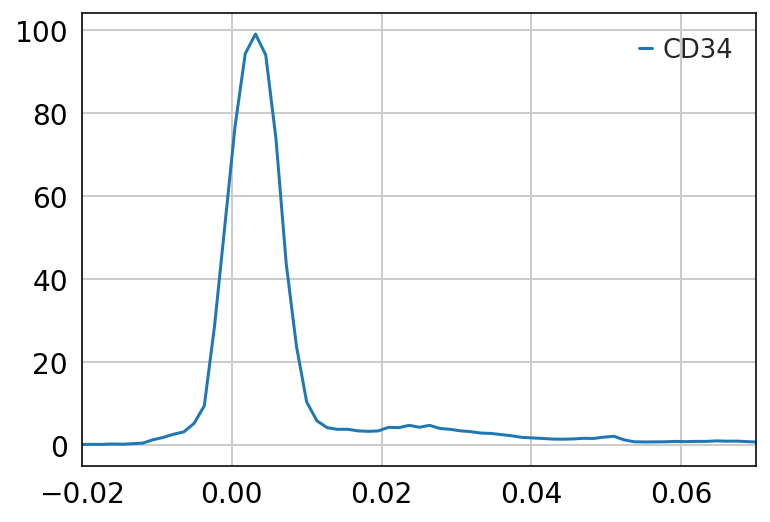

In [13]:
# Plot density
sns.kdeplot(cd34.loc[:, 'CD34'])
plt.xlim([-0.02, 0.07])

Based on this density estimate in imputed gene space, we select cells with high expression, or greater than 0.02, which yields 41133 total cells passing the filter.

In [14]:
imputed_mask = (cd34['CD34'] > 0.02)
print(
    'Number of cells passing filter: %d. Fraction of cells passing filter: %f' % 
    (imputed_mask.sum(), imputed_mask.sum() / imputed_mask.shape[0])
)

Number of cells passing filter: 41133. Fraction of cells passing filter: 0.108817


Then, we choose to sample 2500 additional cells. 

In [15]:
cd34_cells = sample_masked(
    adata=raw,
    n_cells=2500,
    cell_mask=np.array(imputed_mask),
    with_replacement=False
)

cd34_cells

View of AnnData object with n_obs × n_vars = 2500 × 33694 
    var: 'gene_ids'

## Compute scores for the new set of cells

The sampled CD34_high cells are combined with the initial sample and the scores are recomputed

In [16]:
curr_cells = init_set.union(cd34_cells.obs_names)
dist, ref_sphere_counts = sde.determine_distance(curr_cells)
print(dist)

0.6498


In [17]:
# The distance computation can be sped up by computing the reference sphere occupancy
# only on the sampled subset and using the following snippet to compute the overall distance
_, cd34_ref_sphere_counts = sde.determine_distance(cd34_cells.obs_names)
sde.determine_distance_from_occupancy(init_ref_sphere_counts + cd34_ref_sphere_counts)

0.6498

The distance has dropped, as we now cover a greater part of the complete phenotypic space. However, the Jamboree groups should be able to do much better than this very naive approach!

In [18]:
# Create a raw adata object with all the cells
curr_adata = raw[raw.obs_names.isin(curr_cells),]